# Demo for the Simulation-CurveFitting Strategy 
Subsample type: Poisson subsampling (random subset size)

Key params: 
- subsampling ratio for each individual (example) $q \in [0,1.0]$: a sequence of pre-defined real numbers; 
- noise multiplier `sigma`: the normalized noise level $\varepsilon$, i.e., std of Gaussian noise divided by global L2-norm sensitivity C;
- `delta`: the target DP parameter $\delta$.

In [1]:
# generate 6000 samples
import numpy as np
import sys
sys.path.append('../..')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'}) # 轮廓线
# sns.set_palette(palette=sns.color_palette('bright')) # 颜色
legend_font = {'style': 'normal', 'size': 8, 'weight': "normal"}
label_font = {'family':'sans-serif', 'size': 10.5, 'weight': "normal"}
title_font = {'family':'sans-serif', 'size': 10.5, 'weight': "bold"}

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import math
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from pynverse import inversefunc

# Settings for SGD
noise_multiplier = 1.0
inner_steps = 5
target_delta = 1e-3

# Settings for Fed
outer_steps = 20
client_rates = [0.8, 0.5, 0.2]

# Exponential func
# func = lambda x, a, b, c: a * np.exp(b*x) + c
func = lambda x, a, b, c: np.exp(a*x + b) + c
func_str = lambda a, b, c: f"exp({a:.2f}q+{b:.2f}){c:.2f}"
# pre-defined rdp order list
dense = 1.07
orders = [int(dense ** i + 1) for i in range(int(math.floor(math.log(1000, dense))) + 1)]
orders = np.unique(orders)

# pre-defined sampling ratios
sample_rates_examples = [0.001, 0.01, 0.1, 0.5, 0.9, 1.0]

sample_rates = []
tmp_list = [1,2,3,4,5,6,7,8,9,10]
for mul in [0.1,0.01,0.001]:
    sample_rates.extend(list(map(lambda x: x * mul, tmp_list)))
sample_rates = sorted(np.unique(sample_rates))[1:] # delete q = 0.0
sample_rates = np.array(sample_rates, dtype=np.float32)


# sample_rates = np.concatenate([np.arange(0, 1.0, 0.01), np.arange(0, 0.1, 0.001), [1.0]])
# sample_rates = sorted(np.unique(sample_rates))[1:] # delete q = 0.0

# Baseine: Binary Search

In [2]:
# from typing import Optional

# MAX_SAMPLE_RATE = 1.0
# MIN_SAMPLE_RATE = 1e-4
# def get_sample_rate(
#     target_epsilon: float,
#     target_delta: float,
#     sigma: float,
#     steps: Optional[int],
#     accountant: str = "rdp",
#     epsilon_tolerance: float = 0.01,
#     **kwargs,
# ) -> float:
#     r"""
#     Computes the sample rate q to reach a total budget of (target_epsilon, target_delta)
#     at the end of epochs, with a given sample_rate

#     Args:
#         target_epsilon: the privacy budget's epsilon
#         target_delta: the privacy budget's delta
#         sample_rate: the sampling rate (usually batch_size / n_data)
#         epochs: the number of epochs to run
#         steps: number of steps to run
#         accountant: accounting mechanism used to estimate epsilon
#         epsilon_tolerance: precision for the binary search
#     Returns:
#         The noise level sigma to ensure privacy budget of (target_epsilon, target_delta)
#     """
#     accountant = RDPAccountant()
#     q_low, q_high = 0.0, 1.0
#     accountant.history = [(sigma, q_high, steps)]
#     eps_high = accountant.get_epsilon(delta=target_delta)

#     if eps_high <= target_epsilon:
#         return 1.0
    
#     accountant.history = [(sigma, MIN_SAMPLE_RATE, steps)]
#     eps_low = accountant.get_epsilon(delta=target_delta)
#     if eps_low > target_epsilon:
#         raise ValueError("The privacy budget is too low.")

#     while np.abs(target_epsilon - eps_high) > epsilon_tolerance:
#         q = (q_low + q_high) / 2
#         accountant.history = [(sigma, q, steps)]
#         eps = accountant.get_epsilon(delta=target_delta)

#         if eps > target_epsilon:
#             q_high = q
#             eps_high = eps
#         else:
#             q_low = q

#     return q_high

# sample_rates = []
# for e in target_epsilons:
#     best_q = get_sample_rate(target_epsilon=e,
#                              target_delta=1e-5,
#                              sigma=10.0,
#                              steps=100,
#                              accountant="rdp")
#     sample_rates.append(best_q)
#     print(best_q)

# Simulation-CurveFitting

In [21]:
from fedrpdp.accountants.rdp import RDPAccountant, compute_rdp_4fed, compute_rdp_4sgd
from fedrpdp.accountants.analysis import rdp as privacy_analysis

all_examples, all_popts, all_r2 = [], [], []

examples = []
for outer_rate in client_rates:
    examples = []
    for inner_rate in sample_rates:
        total_rdp = compute_rdp_4fed(
                noise_multiplier=noise_multiplier,
                inner_rate=inner_rate, 
                outer_rate=outer_rate, 
                inner_steps=inner_steps, 
                outer_steps=outer_steps,
                alphas=orders)
        eps, _ = privacy_analysis.get_privacy_spent(
            orders=orders, rdp=total_rdp, delta=target_delta)
        examples.append(eps)
        
    examples = np.array(examples, dtype=np.float32) 
    all_examples.append(examples)
        
    popt, _ = curve_fit(func, sample_rates, examples)
    all_popts.append(popt)
    
    r2 = r2_score(func(sample_rates, *popt), examples)
    all_r2.append(r2)
    print('r2 score of the curve fitting.', r2)
    
examples = []
for inner_rate in sample_rates:
    total_rdp = compute_rdp_4sgd(
            noise_multiplier=noise_multiplier,
            sample_rate=inner_rate, 
            steps=inner_steps*outer_steps,
            alphas=orders
        )
    # access the best alpha
    eps, _ = privacy_analysis.get_privacy_spent(
        orders=orders, rdp=total_rdp, delta=target_delta)
    examples.append(eps)
examples = np.array(examples, dtype=np.float32)
all_examples.append(examples)

popt, _ = curve_fit(func, sample_rates, examples)
all_popts.append(popt)

r2 = r2_score(func(sample_rates, *popt), examples)
all_r2.append(r2)
print('r2 score of the curve fitting.', r2)

../../fedrpdp/accountants/analysis/rdp.py:358: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


r2 score of the curve fitting. 0.9985698731108661


../../fedrpdp/accountants/analysis/rdp.py:358: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


r2 score of the curve fitting. 0.9983548180748478


../../fedrpdp/accountants/analysis/rdp.py:358: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


r2 score of the curve fitting. 0.9983093666365426


../../fedrpdp/accountants/analysis/rdp.py:358: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


r2 score of the curve fitting. 0.9987151727435745


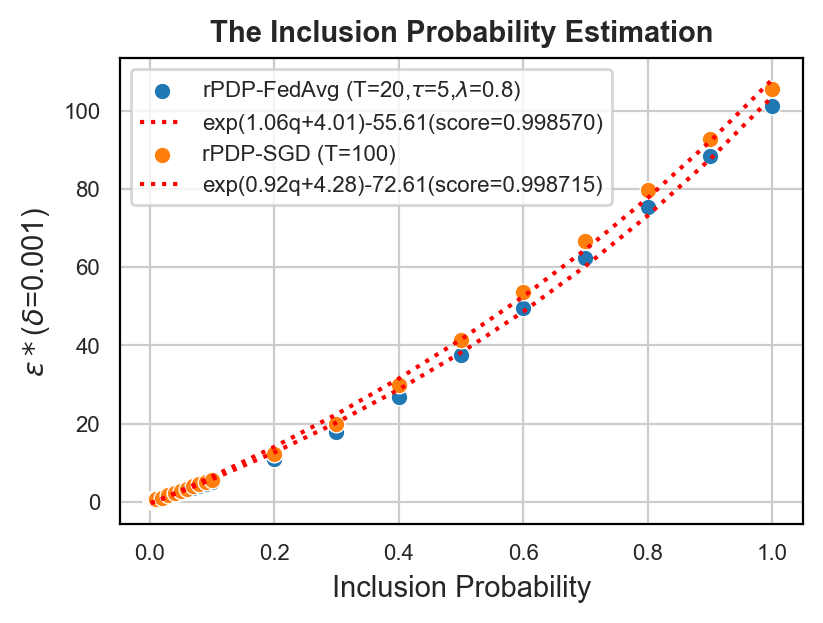

In [22]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True, dpi=200)

for idx in [0]:
    sns.scatterplot(x=sample_rates, y=all_examples[0], label=f'rPDP-FedAvg (T={outer_steps},$\\tau$={inner_steps},$\\lambda$={client_rates[idx]})', ax=ax) 
    sns.lineplot(x=sample_rates, y=func(sample_rates, *all_popts[idx]), 
                 label=func_str(all_popts[idx][0],all_popts[idx][1],all_popts[idx][2])+f"(score={all_r2[idx]:7.6f})", 
                 color='red', linestyle='dotted', ax=ax)

idx = -1
sns.scatterplot(x=sample_rates, y=all_examples[idx], label=f'rPDP-SGD (T={inner_steps*outer_steps})', ax=ax) 
sns.lineplot(x=sample_rates, y=func(sample_rates, *all_popts[-1]), 
             label=func_str(all_popts[-1][0],all_popts[-1][1],all_popts[-1][2])+f'(score={r2:7.6f})', color='red', linestyle='dotted', ax=ax)

ax.legend(prop=legend_font)
ax.set_ylabel(fr'$\varepsilon*$($\delta$={target_delta})', **label_font)
ax.set_xlabel('Inclusion Probability', **label_font)
ax.tick_params(labelsize=8) #刻度
ax.set_title('The Inclusion Probability Estimation', **title_font)
plt.show()

In [23]:
simu_results_fedlearn = []
for inner_rate in sample_rates_examples:
    rdp = compute_rdp_4fed(
        noise_multiplier=noise_multiplier,
        inner_rate=inner_rate, 
        outer_rate=client_rates[1], # 0.2, 0.5, 0.8 
        inner_steps=inner_steps, 
        outer_steps=outer_steps,
        alphas=orders
    )
    orders_vec = np.atleast_1d(orders)
    rdp_vec = np.atleast_1d(rdp)
    eps_vec = (
        rdp_vec
        - (np.log(target_delta) + np.log(orders_vec)) / (orders_vec - 1)
        + np.log((orders_vec - 1) / orders_vec)
    )
    simu_results_fedlearn.append(eps_vec)

/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == "":


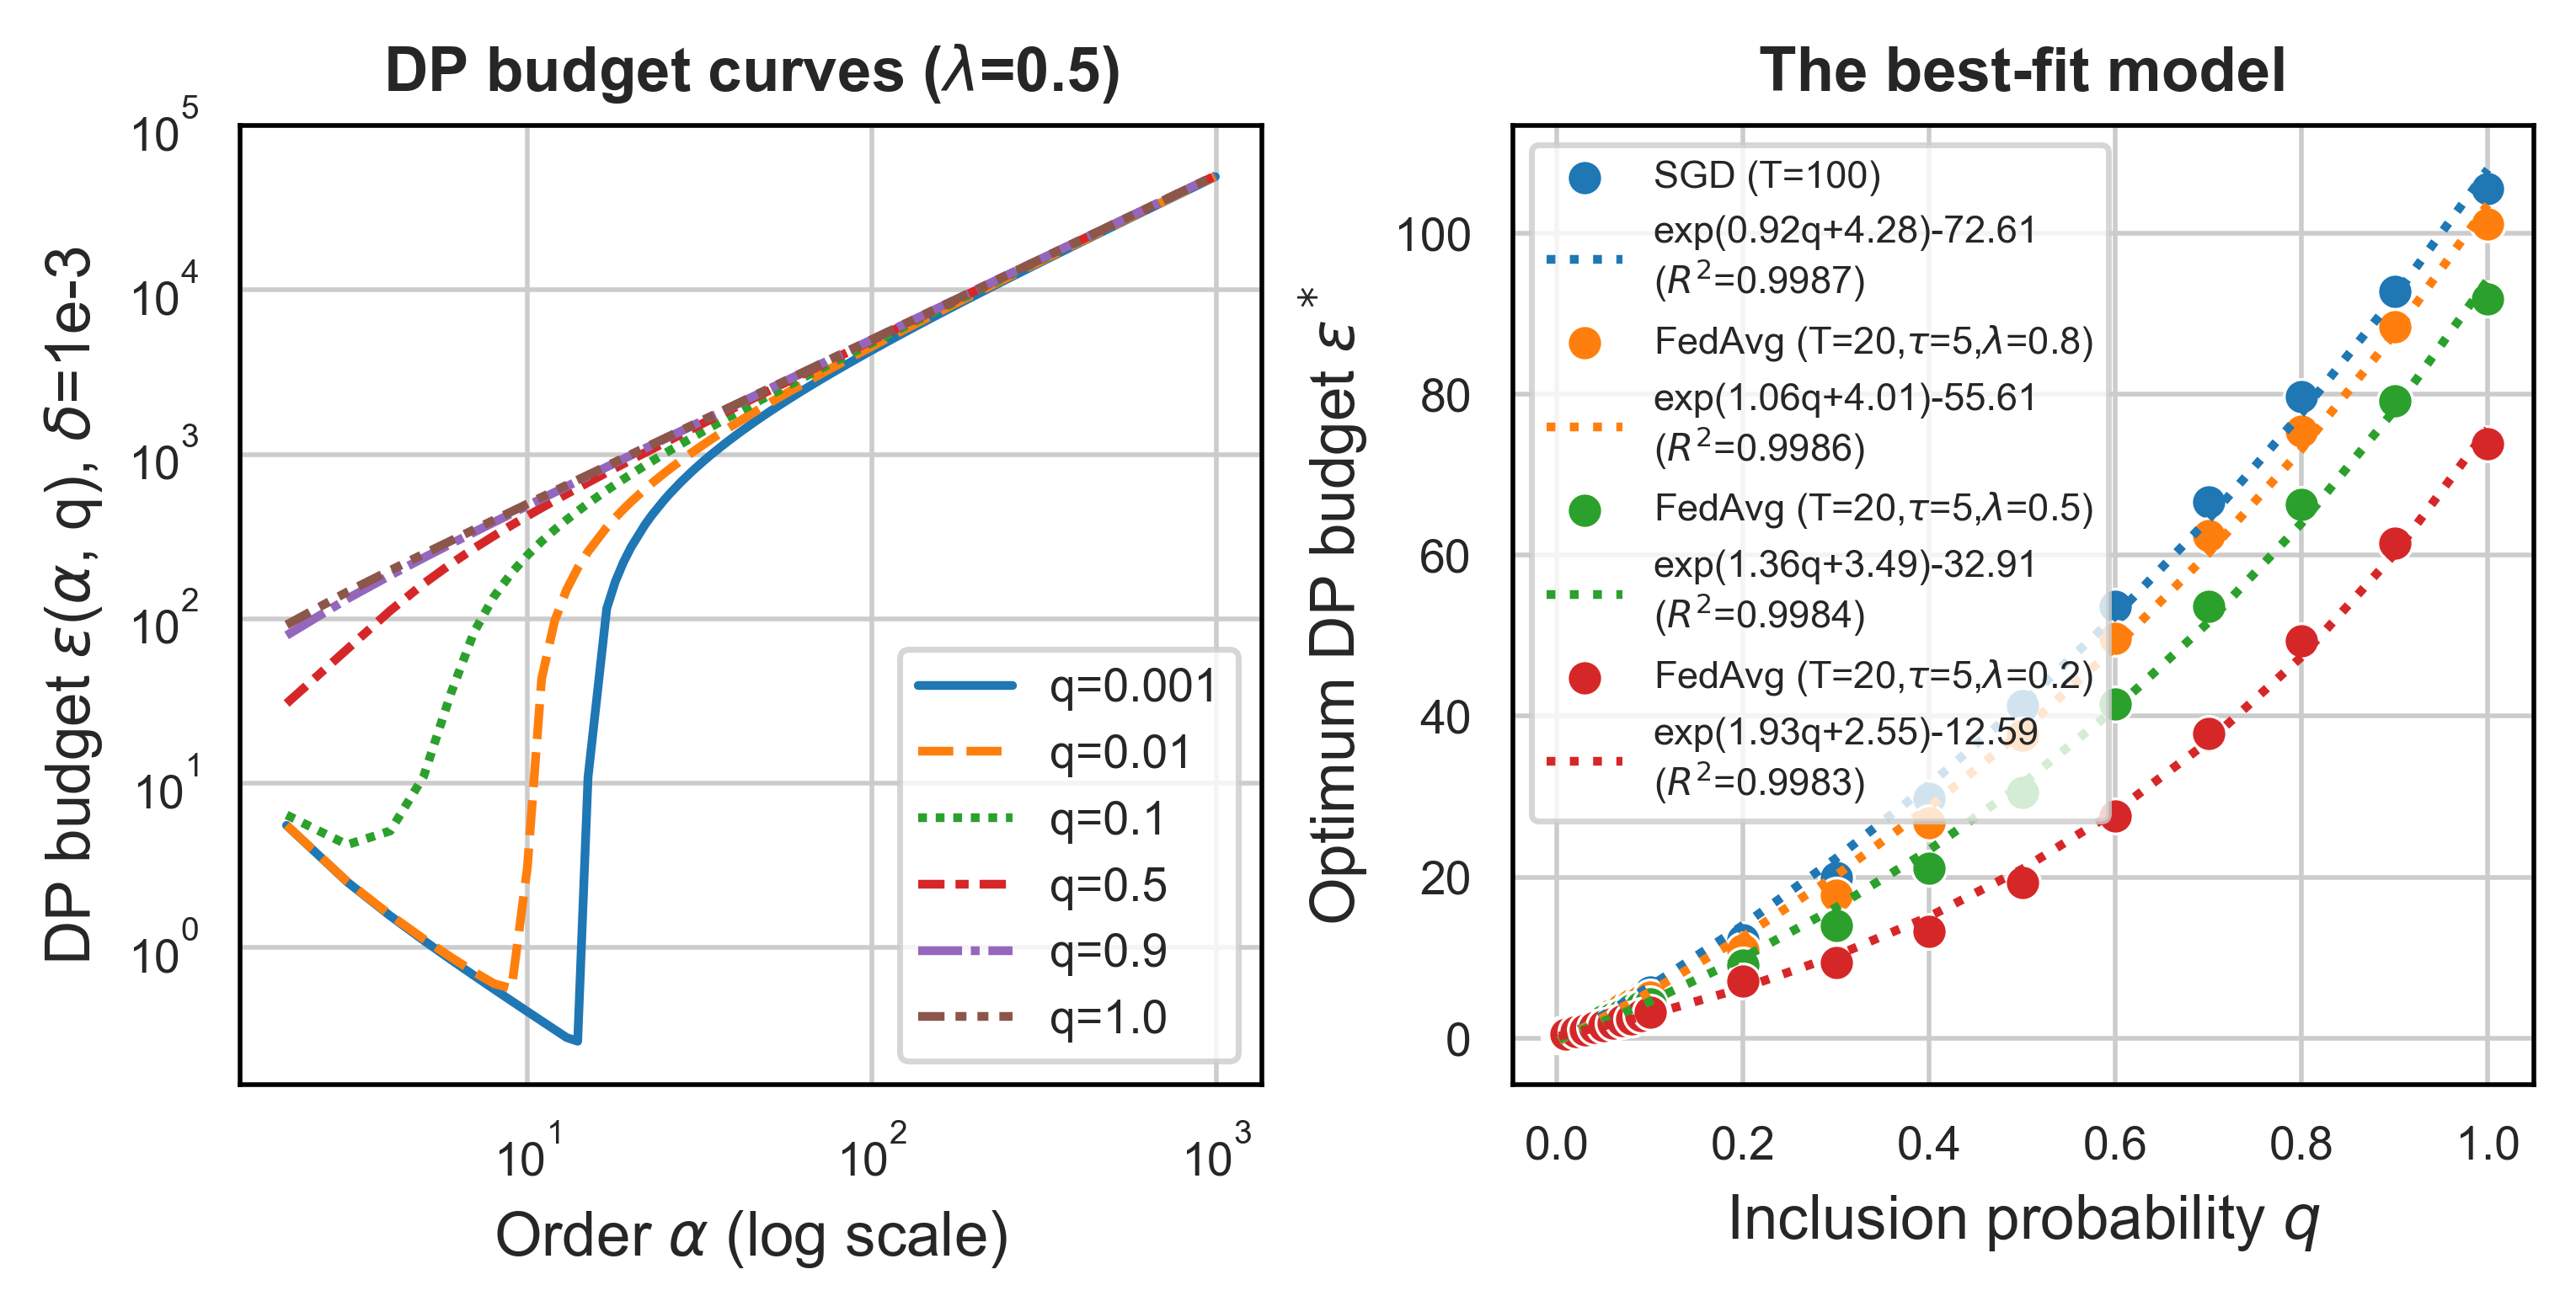

In [31]:
colname = [rf'q={q}' for q in sample_rates_examples]

plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True, dpi=500)

# dp curve w.r.t. order alpha
df1 = pd.DataFrame(simu_results_fedlearn, columns=orders, index=colname)
df1_T = pd.DataFrame(df1.T, columns=colname, index=orders)
sns.lineplot(data=df1_T, ax=axs[0])
axs[0].set(xscale="log", yscale="log")
axs[0].set_ylabel(r'DP budget $\varepsilon$($\alpha$, q), $\delta$=1e-3', **label_font)
axs[0].set_ylim(0, 100000)
axs[0].set_xlabel(r'Order $\alpha$ (log scale)', **label_font)
axs[0].tick_params(labelsize=8)
axs[0].set_title(rf'DP budget curves ($\lambda$={client_rates[1]})', **title_font)
axs[0].legend(prop=legend_font)
# axs[0].set_ylabel(r'$\varepsilon^*$', **label_font)
# axs[0].set_xlabel('Inclusion Probability', **label_font)
# axs[0].tick_params(labelsize=8) #刻度

idx = -1
sns.scatterplot(x=sample_rates, y=all_examples[idx], label=f'SGD (T={inner_steps*outer_steps})', ax=axs[1]) 
sns.lineplot(x=sample_rates, y=func(sample_rates, *all_popts[-1]), 
             label=func_str(all_popts[-1][0],all_popts[-1][1],all_popts[-1][2])+f'\n($R^2$={r2:5.4f})', 
             linestyle='dotted', ax=axs[1])

for idx, outer_rate in enumerate(client_rates):
    sns.scatterplot(x=sample_rates, y=all_examples[idx], label=f'FedAvg (T={outer_steps},$\\tau$={inner_steps},$\\lambda$={outer_rate})', ax=axs[1]) 
    sns.lineplot(x=sample_rates, y=func(sample_rates, *all_popts[idx]), 
                 label=func_str(all_popts[idx][0],all_popts[idx][1],all_popts[idx][2])+f"\n($R^2$={all_r2[idx]:5.4f})", 
                 linestyle='dotted', ax=axs[1])


axs[1].legend(prop={'size': 6.5})
axs[1].set_ylabel(r'Optimum DP budget $\varepsilon^*$', **label_font)
axs[1].set_xlabel('Inclusion probability $q$', **label_font)
axs[1].tick_params(labelsize=8) #刻度
axs[1].set_title(r'The best-fit model', **title_font)

# fig.suptitle('The Inclusion Probability Estimation ($\delta$={}, $\sigma$/L={})'.format(target_delta,sigma), fontsize=10, weight='bold')
plt.savefig('inclusion_estimator_fed.pdf', dpi=500, bbox_inches='tight')
plt.show()

# Estimation using the results of Wang et al.

In [7]:
from autodp import rdp_acct, utils
from autodp.mechanism_zoo import GaussianMechanism

def numerical_simu_analysis(sample_rates, noise_multiplier, steps, alpha):
    results = {
        'rdp_curve':[],
        'eps_curve':[], 
        'opt_budget':[], 
        'opt_order':[]
    }
    mech = GaussianMechanism(sigma=noise_multiplier)
    for q in sample_rates:
        acct = rdp_acct.anaRDPacct()
        acct.compose_poisson_subsampled_mechanisms(mech.RenyiDP, q)
        acct.build_zeroth_oracle()
        rdp_list = [acct.RDPs[0](a)*steps for a in alpha]
        eps_list = [rdp + np.log(1 / target_delta) / (a - 1) for (a, rdp) in zip(alpha, rdp_list)]
        idx_opt = np.nanargmin(eps_list)  # Ignore NaNs
        results['rdp_curve'].append(rdp_list)
        results['eps_curve'].append(eps_list)
        results['opt_budget'].append(eps_list[idx_opt])
        results['opt_order'].append(alpha[idx_opt])
        print("q=", q, ", opt order=", alpha[idx_opt], ", opt eps=", eps_list[idx_opt], ", delta=", target_delta)
        del acct
    return results

def get_max_effective_budget(noise_multiplier, steps, alpha):
    mech = GaussianMechanism(sigma=noise_multiplier)
    rdp_list = [mech.get_RDP(a)*steps for a in alpha]
    eps_list = [rdp + np.log(1 / target_delta) / (a - 1) for (a, rdp) in zip(alpha, rdp_list)]
    idx_opt = np.nanargmin(eps_list)  # Ignore NaNs
    print('the maximum effective budget: ', eps_list[idx_opt], alpha[idx_opt])
    return eps_list[idx_opt]

## 1) RDP & DP budget curve (Single Query)

In [8]:
simu_results_naive = numerical_simu_analysis(
    sample_rates=sample_rates_examples, 
    noise_multiplier=noise_multiplier, 
    alpha=orders, steps=1
)
opt_budgets_naive = simu_results_naive['opt_budget']
max_budget_naive = get_max_effective_budget(
    noise_multiplier=noise_multiplier, 
    alpha=orders, steps=1
)
print(opt_budgets_naive[-1], max_budget_naive)
assert opt_budgets_naive[-1] == max_budget_naive, 'Error in func numerical_simu_analysis.'

q= 0.001 , opt order= 14 , opt eps= 0.5316413434468775 , delta= 0.001
q= 0.01 , opt order= 10 , opt eps= 0.8057987832262972 , delta= 0.001
q= 0.1 , opt order= 6 , opt eps= 1.7526454088727403 , delta= 0.001
q= 0.5 , opt order= 5 , opt eps= 3.38483268618591 , delta= 0.001
q= 0.9 , opt order= 5 , opt eps= 4.097797445921584 , delta= 0.001
q= 1.0 , opt order= 5 , opt eps= 4.226938819745534 , delta= 0.001
the maximum effective budget:  4.226938819745534 5
4.226938819745534 4.226938819745534


/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/rdp_acct.py:724: RuntimeWarning: divide by zero encountered in log
  + (alpha+1-jvec[0:alpha-1])*np.log(1-prob))
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/utils.py:8: RuntimeWarning: invalid value encountered in subtract
  return a+np.log(np.sum(np.exp(x-a)))
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/rdp_acct.py:725: RuntimeWarning: divide by zero encountered in log
  results[alpha-1] = utils.stable_logsumexp_two((alpha-1)*np.log(1-prob)


## 2) RDP & DP budget curve (SGD)

q= 0.001 , opt order= 14 , opt eps= 0.5589210662853319 , delta= 0.001
q= 0.01 , opt order= 9 , opt eps= 1.0416356142110677 , delta= 0.001
q= 0.1 , opt order= 3 , opt eps= 6.625107669828709 , delta= 0.001
q= 0.5 , opt order= 2 , opt eps= 42.645157229860985 , delta= 0.001
q= 0.9 , opt order= 2 , opt eps= 94.11272356040733 , delta= 0.001
q= 1.0 , opt order= 2 , opt eps= 106.90775527898214 , delta= 0.001
the maximum effective budget:  106.90775527898214 2


/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/rdp_acct.py:724: RuntimeWarning: divide by zero encountered in log
  + (alpha+1-jvec[0:alpha-1])*np.log(1-prob))
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/utils.py:8: RuntimeWarning: invalid value encountered in subtract
  return a+np.log(np.sum(np.exp(x-a)))
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/rdp_acct.py:725: RuntimeWarning: divide by zero encountered in log
  results[alpha-1] = utils.stable_logsumexp_two((alpha-1)*np.log(1-prob)
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


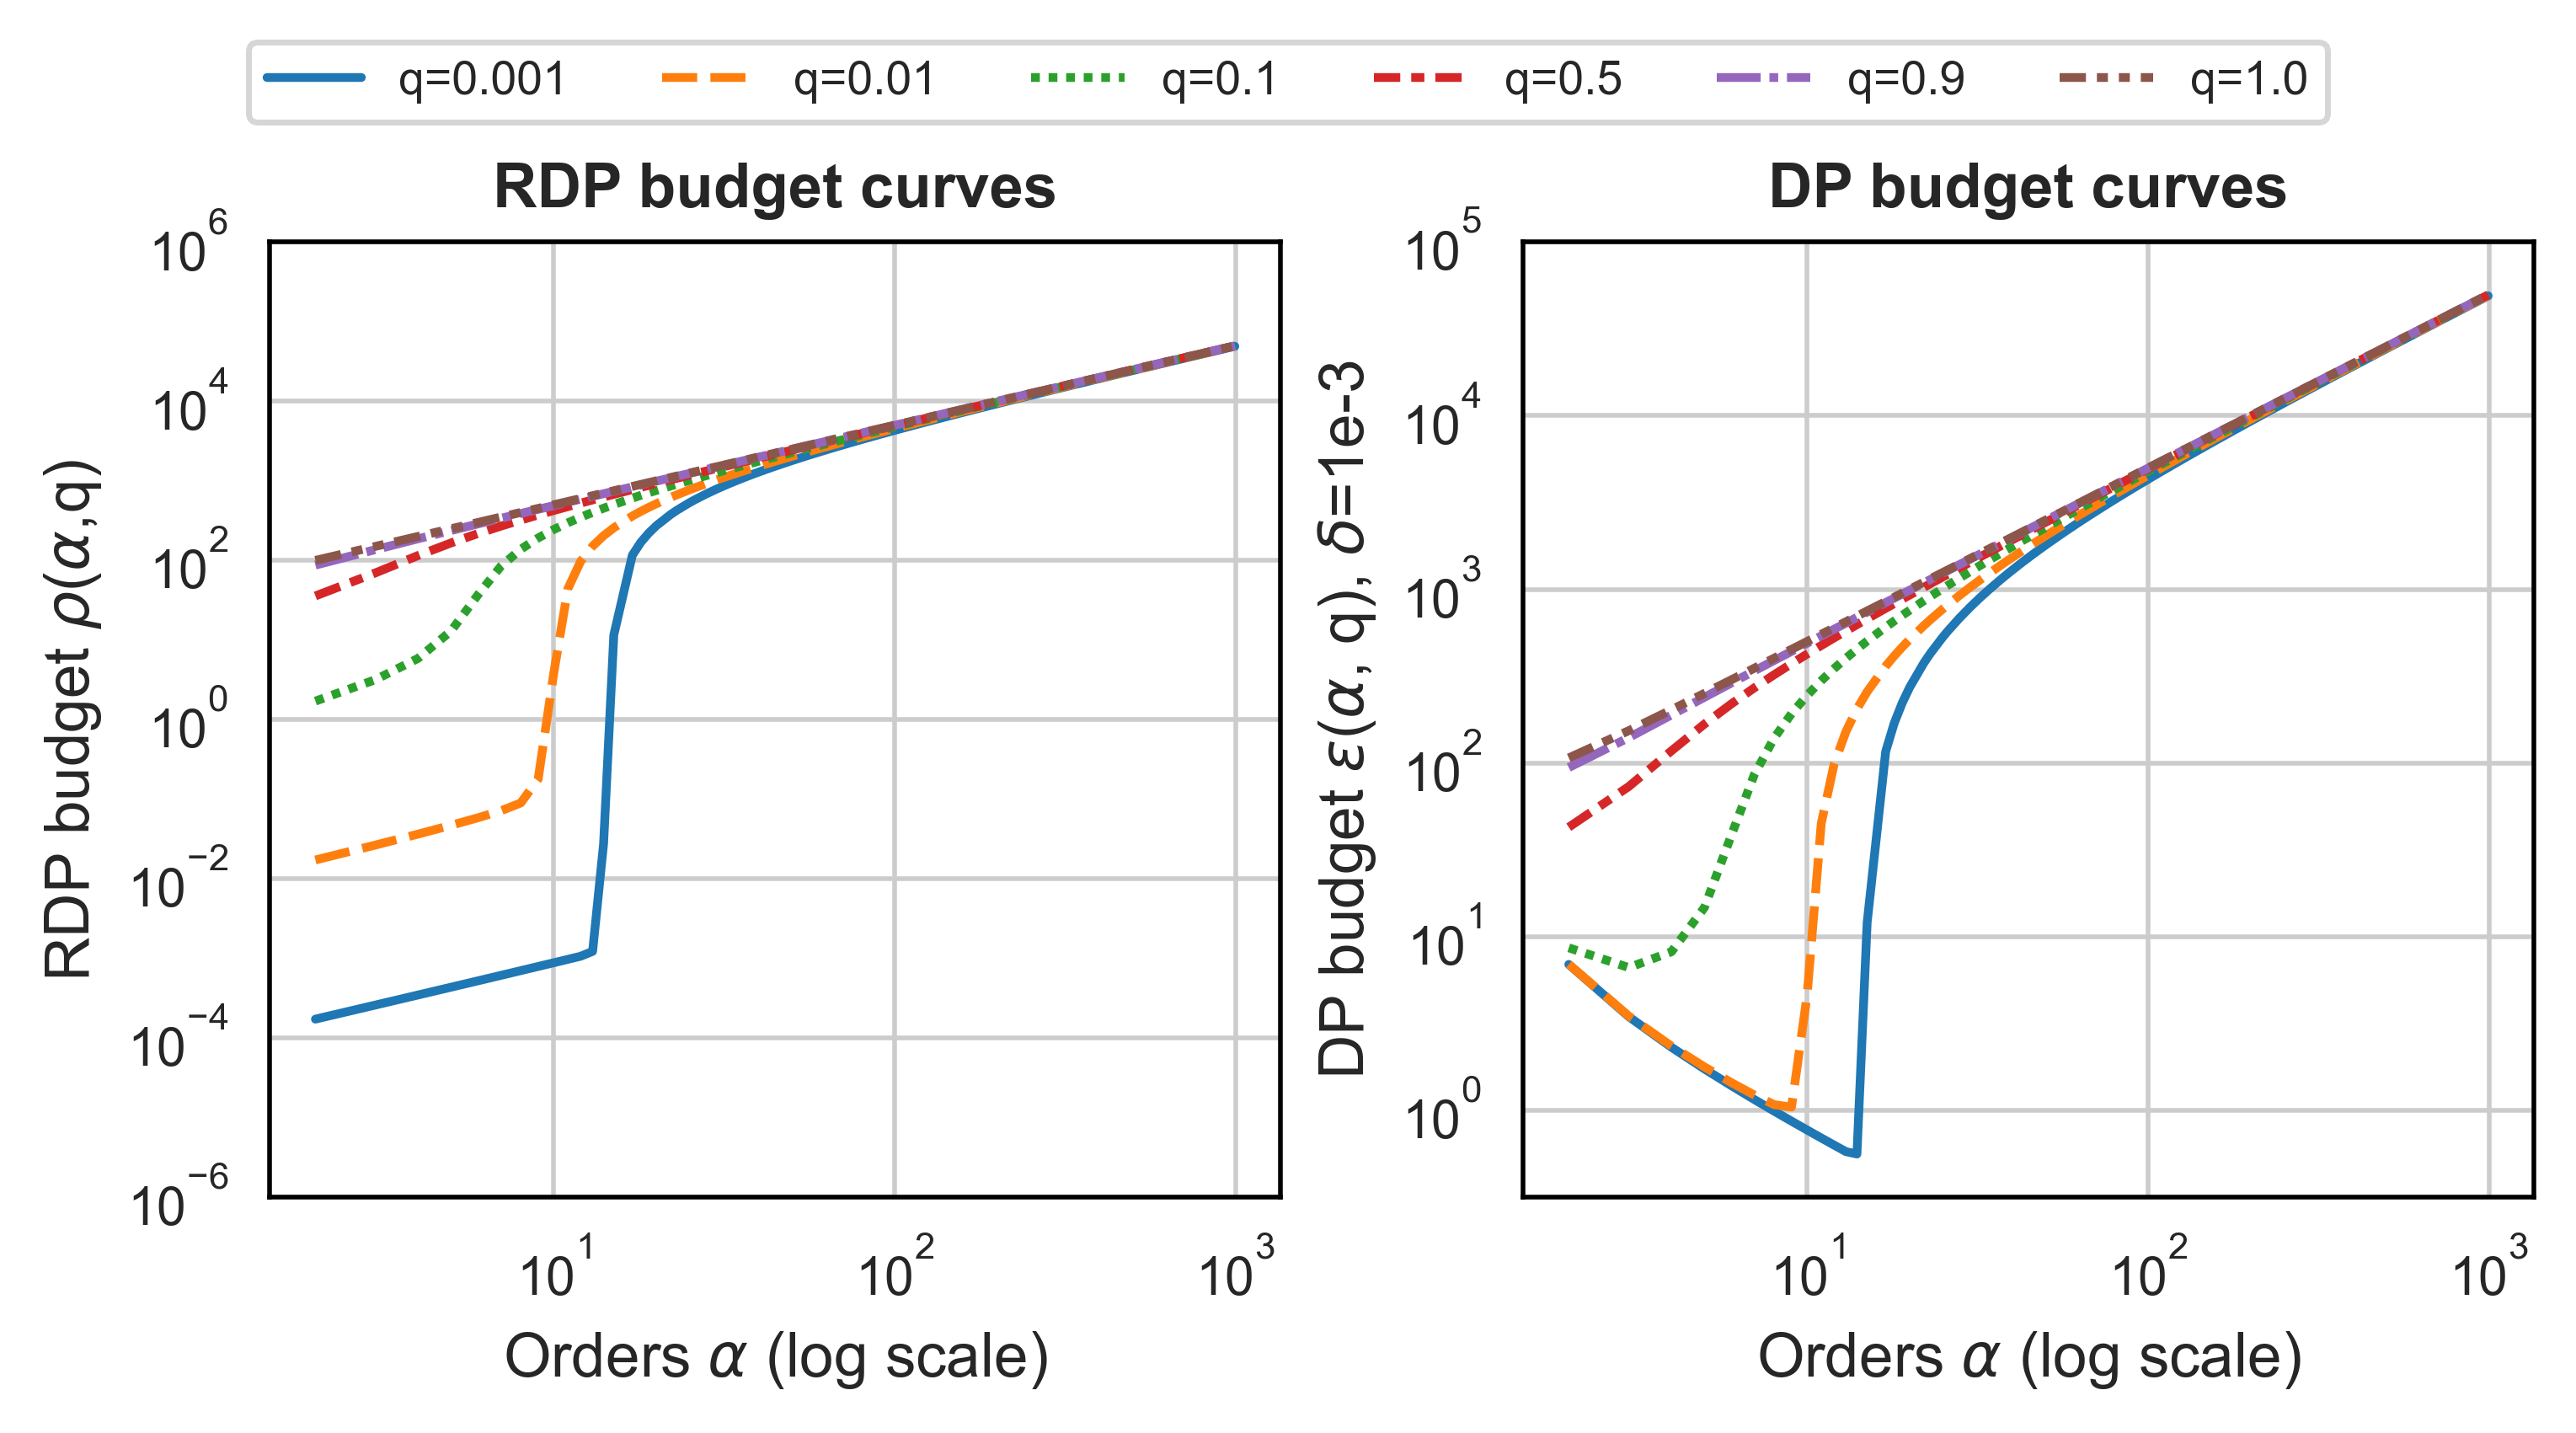

In [32]:
# Vision
simu_results_sgd = numerical_simu_analysis(
    noise_multiplier=noise_multiplier,
    sample_rates=sample_rates_examples, 
    alpha=orders, 
    steps=inner_steps * outer_steps
)

opt_budgets_sgd = simu_results_sgd['opt_budget']
max_budget_sgd = get_max_effective_budget(
    noise_multiplier=noise_multiplier,
    alpha=orders, 
    steps=inner_steps * outer_steps
)
assert opt_budgets_sgd[-1] == max_budget_sgd, 'Error in func numerical_simu_analysis.'

all_results = [simu_results_sgd]
colname = [rf'q={q}' for q in sample_rates_examples]

plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True, dpi=500)

for row in range(1):
    # rdp curve w.r.t. order alpha
    df1 = pd.DataFrame(all_results[row]['rdp_curve'], columns=orders, index=colname)
    df1_T = pd.DataFrame(df1.T, columns=colname, index=orders)
    sns.lineplot(data=df1_T, ax=axs[0])
    axs[0].set(xscale="log", yscale="log")
    axs[0].get_legend().remove()
    axs[0].set_ylim(1e-6, 1e6)
    axs[0].set_ylabel(r'RDP budget $\rho$($\alpha$,q)', **label_font)
    axs[0].set_xlabel(r'Orders $\alpha$ (log scale)', **label_font)
    axs[0].tick_params(labelsize=9) #刻度
    axs[0].set_title('RDP budget curves', **title_font)

    # dp curve w.r.t. order alpha
    df2 = pd.DataFrame(all_results[row]['eps_curve'], columns=orders, index=colname)
    df2_T = pd.DataFrame(df2.T, columns=colname, index=orders)
    sns.lineplot(data=df2_T, ax=axs[1])
    axs[1].set(xscale="log", yscale="log")
    axs[1].get_legend().remove()
    axs[1].set_ylabel(r'DP budget $\varepsilon$($\alpha$, q), $\delta$=1e-3', **label_font)
    axs[1].set_ylim(0, 100000)
    axs[1].set_xlabel(r'Orders $\alpha$ (log scale)', **label_font)
    axs[1].tick_params(labelsize=9)
    axs[1].set_title(r'DP budget curves', **title_font)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor = (0, 0.1, 1, 1), ncol=len(labels), prop=legend_font)
plt.savefig('budget_curve_sgd.pdf', dpi=500, bbox_inches='tight')
plt.show()

## 3) RDP & DP budget curves (FedAvg)

In [10]:
def _ternary_search(f, options=None, left=1, right=512, iterations=72): # 利用三叉搜索树寻找最优order
    """Performs a search over a closed domain [left, right] for the value which minimizes f."""
    if options is not None:
        left, right = 0, len(options)-1
        for i in range(iterations):
            left_third = max(0, int(left + (right - left) / 3))
            right_third = min(int(right - (right - left) / 3), len(options)-1)
            # print(left_third, f(options[left_third]), right_third, f(options[right_third]))
            if f(options[left_third]) <= f(options[right_third]):
                if right_third == right:
                    break
                right = right_third
            else:
                if left_third == left:
                    break
                left = left_third
            # print(left, right)
        
        if left == right:
            opt_order = options[right]
            return opt_order, f(opt_order)
        elif right-left == 1:
            eps1 = f(options[left])
            eps2 = f(options[right])
            if eps1 < eps2:
                # print('eps1: ', eps1, 'eps2: ', eps2)
                # print(options[left], eps1)
                return options[left], eps1
            else:
                return options[right], eps2
        else:
            opt_order = options[int((left + right) / 2)]
            return opt_order, f(opt_order)

    else:
        for i in range(iterations):
            left_third = left + (right - left) / 3
            right_third = right - (right - left) / 3
            if f(left_third) < f(right_third):
                right = right_third
            else:
                left = left_third
        # print('==> ternary_search: ', i, left, right)
        return (left + right) / 2

def _two_stage_subsampled_gauss_rdp_analysis(rdp_func, order, inner_steps, outer_steps, outer_rate):
    r"""
    rdp_func: the `rho_{i,j}^\tau` param in the paper.
    
    """
    assert order > 1.0, "the RDP order must larger than 1!"
    assert outer_rate > 0.0, "the client sampling ratio must larger than 0!"
    
    log_term_1 = np.log(1-outer_rate)
    log_term_2 = np.log(outer_rate) + (order-1) * inner_steps * rdp_func(order)
    rdp_stage1 = 1.0*utils.stable_logsumexp([log_term_1, log_term_2])/(order-1)
    
    return rdp_stage1 * outer_steps

def _apply_pdp_sgd_analysis(rdp_func, order, inner_steps, outer_steps, outer_rate):
    rdp = _two_stage_subsampled_gauss_rdp_analysis(
        rdp_func, order, inner_steps, outer_steps, outer_rate
    )
    eps = rdp + np.log(1/target_delta) / (order-1)
    return eps

def epsilon(rdp_func, tau, T, p, delta, orders=None):
    if orders is not None:
        optimal_order, epsilon = _ternary_search(lambda order: _apply_pdp_sgd_analysis(rdp_func, order, tau, T, p, delta), options=orders, iterations=72)
    else:
        ## TODO: have not been updated
        optimal_order, epsilon = _ternary_search(lambda order: _apply_pdp_sgd_analysis(rdp_func, order, tau, T, p, delta), left=1, right=512, iterations=100)
    return  optimal_order, epsilon

def numerical_simu_analysis_fedlearn(noise_multiplier, inner_steps, inner_rates, outer_steps, outer_rate, alpha):
    results = {
        'rdp_curve':[],
        'eps_curve':[], 
        'opt_budget':[], 
        'opt_order':[],
    }
    mech = GaussianMechanism(sigma=noise_multiplier)
    for q in inner_rates:
        acct = rdp_acct.anaRDPacct()
        acct.compose_poisson_subsampled_mechanisms(mech.RenyiDP, q)
        acct.build_zeroth_oracle()
        rdp_list = [_two_stage_subsampled_gauss_rdp_analysis(
            acct.RDPs[0], order=a, 
            inner_steps=inner_steps, 
            outer_steps=outer_steps, 
            outer_rate=outer_rate) for a in alpha]
        eps_list = [rdp + np.log(1 / target_delta) / (a - 1) for (a, rdp) in zip(alpha, rdp_list)]
        idx_opt = np.nanargmin(eps_list)  # Ignore NaNs
        results['rdp_curve'].append(rdp_list)
        results['eps_curve'].append(eps_list)
        results['opt_budget'].append(eps_list[idx_opt])
        results['opt_order'].append(alpha[idx_opt])
        print("q=", q, ", opt order=", alpha[idx_opt], ", opt eps=", eps_list[idx_opt], ", delta=", target_delta)
        del acct
    return results

def get_max_effective_budget_fedlearn(noise_multiplier, inner_steps, outer_steps, outer_rate, alpha):
    mech = GaussianMechanism(sigma=noise_multiplier)
    rdp_list = [
        _two_stage_subsampled_gauss_rdp_analysis(
            mech.get_RDP, 
            order=a, 
            inner_steps=inner_steps, 
            outer_steps=outer_steps, 
            outer_rate=outer_rate
        ) 
        for a in alpha
    ]
    eps_list = [rdp + np.log(1 / target_delta) / (a - 1) for (a, rdp) in zip(alpha, rdp_list)]
    idx_opt = np.nanargmin(eps_list)  # Ignore NaNs
    print('the maximum effective budget: ', eps_list[idx_opt], alpha[idx_opt])
    return eps_list[idx_opt]

q= 0.001 , opt order= 14 , opt eps= 0.5369164705333472 , delta= 0.001
q= 0.01 , opt order= 9 , opt eps= 0.9001329250317792 , delta= 0.001
q= 0.1 , opt order= 4 , opt eps= 3.959886547860844 , delta= 0.001
q= 0.5 , opt order= 2 , opt eps= 20.712083822916085 , delta= 0.001
q= 0.9 , opt order= 2 , opt eps= 62.92072627447718 , delta= 0.001
q= 1.0 , opt order= 2 , opt eps= 75.25089673714797 , delta= 0.001
the maximum effective budget:  75.25089673714797 2


/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/rdp_acct.py:724: RuntimeWarning: divide by zero encountered in log
  + (alpha+1-jvec[0:alpha-1])*np.log(1-prob))
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/utils.py:8: RuntimeWarning: invalid value encountered in subtract
  return a+np.log(np.sum(np.exp(x-a)))
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/rdp_acct.py:725: RuntimeWarning: divide by zero encountered in log
  results[alpha-1] = utils.stable_logsumexp_two((alpha-1)*np.log(1-prob)
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


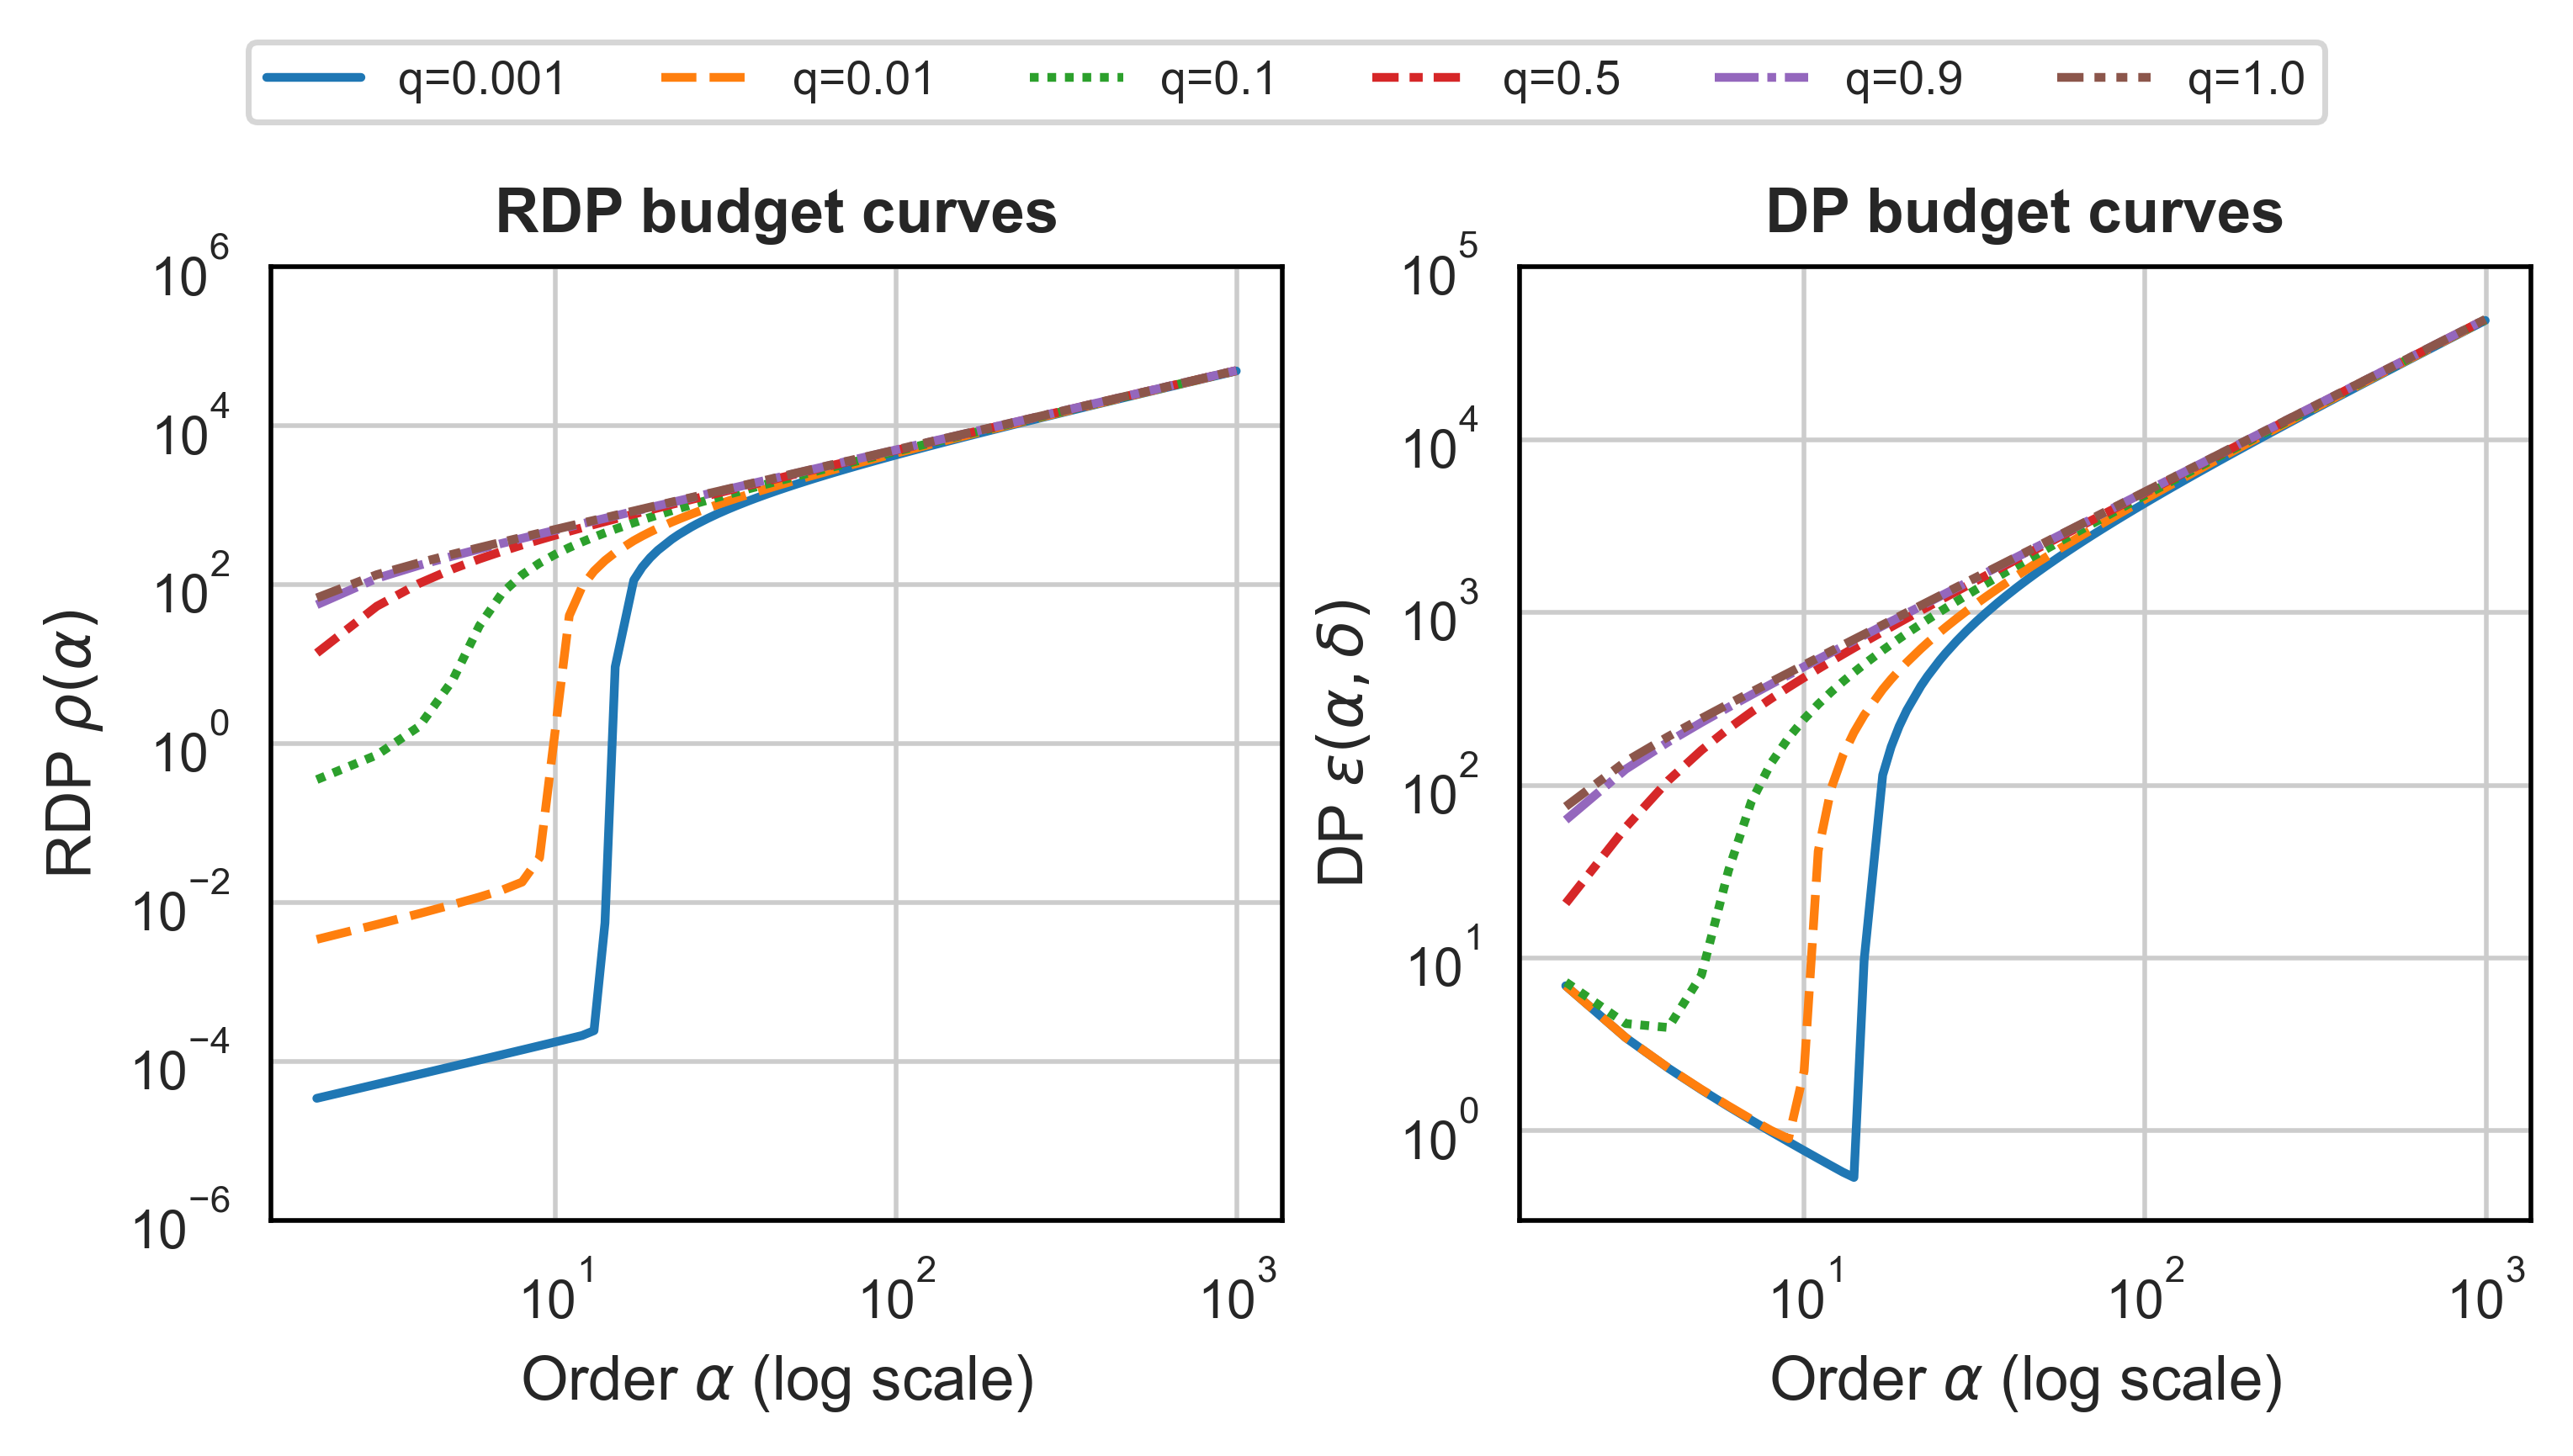

In [11]:
# Vision
simu_results_fedlearn = numerical_simu_analysis_fedlearn(
    noise_multiplier=noise_multiplier,
    inner_rates=sample_rates_examples, 
    inner_steps=inner_steps, 
    outer_steps=outer_steps, 
    outer_rate=outer_rate,
    alpha=orders)
opt_budgets_fedlearn = simu_results_fedlearn['opt_budget']
max_budget_fedlearn = get_max_effective_budget_fedlearn(
    noise_multiplier=noise_multiplier,
    inner_steps=inner_steps, 
    outer_steps=outer_steps, 
    outer_rate=outer_rate,
    alpha=orders) # for samp_prob = 1.0
assert opt_budgets_fedlearn[-1] == max_budget_fedlearn, 'Error in func numerical_simu_analysis.'

all_results = [simu_results_fedlearn]
colname = [rf'q={q}' for q in sample_rates_examples]

plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True, dpi=500)
for row in range(1):
    # rdp curve w.r.t. order alpha
    df1 = pd.DataFrame(all_results[row]['rdp_curve'], columns=orders, index=colname)
    df1_T = pd.DataFrame(df1.T, columns=colname, index=orders)
    sns.lineplot(data=df1_T, ax=axs[0])
    axs[0].set(xscale="log", yscale="log")
    axs[0].get_legend().remove()
    axs[0].set_ylim(1e-6, 1e6)
    axs[0].set_ylabel(r'RDP $\rho(\alpha)$', **label_font)
    axs[0].set_xlabel(r'Order $\alpha$ (log scale)', **label_font)
    axs[0].tick_params(labelsize=9) #刻度
    axs[0].set_title('RDP budget curves', **title_font)

    # dp curve w.r.t. order alpha
    df2 = pd.DataFrame(all_results[row]['eps_curve'], columns=orders, index=colname)
    df2_T = pd.DataFrame(df2.T, columns=colname, index=orders)
    sns.lineplot(data=df2_T, ax=axs[1])
    axs[1].set(xscale="log", yscale="log")
    axs[1].get_legend().remove()
    axs[1].set_ylabel(r'DP $\varepsilon(\alpha, \delta)$', **label_font)
    axs[1].set_ylim(0, 100000)
    axs[1].set_xlabel(r'Order $\alpha$ (log scale)', **label_font)
    axs[1].tick_params(labelsize=9)
    axs[1].set_title(r'DP budget curves', **title_font)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor = (0, 0.12, 1, 1), ncol=len(labels), prop=legend_font)
plt.savefig('budget_curve_fed.pdf', dpi=500, bbox_inches='tight')
plt.show()

# Vision of the approximated sampling curve

# simu_results_sgd_full, simu_results_fed_full

In [12]:
simu_results_sgd_full = numerical_simu_analysis(
    noise_multiplier=noise_multiplier,
    sample_rates=sample_rates, 
    alpha=orders, 
    steps=inner_steps*outer_steps
)
opt_budgets_sgd_full = simu_results_sgd_full['opt_budget']
# max_budget_sgd_full = get_max_effective_budget(orders, T=100) # for samp_prob = 1.0
# assert opt_budgets_sgd_full[-1] == max_budget_sgd_full, 'Error in func numerical_simu_analysis.'

simu_results_fedlearn_full_02 = numerical_simu_analysis_fedlearn(
    noise_multiplier=noise_multiplier,
    inner_rates=sample_rates, 
    inner_steps=inner_steps, 
    outer_steps=outer_steps, 
    outer_rate=0.2,
    alpha=orders
)
opt_budgets_fedlearn_full_02 = simu_results_fedlearn_full_02['opt_budget']

simu_results_fedlearn_full_05 = numerical_simu_analysis_fedlearn(
    noise_multiplier=noise_multiplier,
    inner_rates=sample_rates, 
    inner_steps=inner_steps, 
    outer_steps=outer_steps, 
    outer_rate=0.5,
    alpha=orders
)
opt_budgets_fedlearn_full = simu_results_fedlearn_full_05['opt_budget']
# max_budget_fedlearn_full = get_max_effective_budget_fedlearn(orders, tau=5, T=20, _lambda=0.2) # for samp_prob = 1.0
# assert opt_budgets_fedlearn_full[-1] == max_budget_fedlearn_full, 'Error in func numerical_simu_analysis.'

q= 0.002 , opt order= 12 , opt eps= 0.6342686224207869 , delta= 0.001
q= 0.003 , opt order= 11 , opt eps= 0.7016793415966618 , delta= 0.001
q= 0.004 , opt order= 11 , opt eps= 0.7447881752286266 , delta= 0.001
q= 0.005 , opt order= 10 , opt eps= 0.7972049720163162 , delta= 0.001
q= 0.006 , opt order= 10 , opt eps= 0.8340131998072228 , delta= 0.001
q= 0.007 , opt order= 9 , opt eps= 0.9120545699407081 , delta= 0.001
q= 0.008 , opt order= 9 , opt eps= 0.9354590127904405 , delta= 0.001
q= 0.009 , opt order= 9 , opt eps= 0.9739404996379839 , delta= 0.001
q= 0.01 , opt order= 9 , opt eps= 1.0416355530468686 , delta= 0.001
q= 0.02 , opt order= 7 , opt eps= 1.5570101842208688 , delta= 0.001
q= 0.03 , opt order= 6 , opt eps= 2.1667492709347616 , delta= 0.001
q= 0.04 , opt order= 5 , opt eps= 2.774222349656682 , delta= 0.001
q= 0.05 , opt order= 4 , opt eps= 3.4442118426035986 , delta= 0.001
q= 0.06 , opt order= 4 , opt eps= 4.04018863288715 , delta= 0.001
q= 0.07 , opt order= 4 , opt eps= 4.79

/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/rdp_acct.py:724: RuntimeWarning: divide by zero encountered in log
  + (alpha+1-jvec[0:alpha-1])*np.log(1-prob))
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/utils.py:8: RuntimeWarning: invalid value encountered in subtract
  return a+np.log(np.sum(np.exp(x-a)))
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/autodp/rdp_acct.py:725: RuntimeWarning: divide by zero encountered in log
  results[alpha-1] = utils.stable_logsumexp_two((alpha-1)*np.log(1-prob)


q= 0.002 , opt order= 12 , opt eps= 0.6292376690988688 , delta= 0.001
q= 0.003 , opt order= 12 , opt eps= 0.6798523872211774 , delta= 0.001
q= 0.004 , opt order= 11 , opt eps= 0.7016953825682504 , delta= 0.001
q= 0.005 , opt order= 10 , opt eps= 0.773495475805417 , delta= 0.001
q= 0.006 , opt order= 10 , opt eps= 0.7809854124286807 , delta= 0.001
q= 0.007 , opt order= 10 , opt eps= 0.8057730435179088 , delta= 0.001
q= 0.008 , opt order= 9 , opt eps= 0.8780341260727268 , delta= 0.001
q= 0.009 , opt order= 9 , opt eps= 0.8859576049533666 , delta= 0.001
q= 0.01 , opt order= 9 , opt eps= 0.9001329120865773 , delta= 0.001
q= 0.02 , opt order= 7 , opt eps= 1.236482933885026 , delta= 0.001
q= 0.03 , opt order= 6 , opt eps= 1.55140621606304 , delta= 0.001
q= 0.04 , opt order= 6 , opt eps= 1.8281236011812863 , delta= 0.001
q= 0.05 , opt order= 5 , opt eps= 2.1581214565722364 , delta= 0.001
q= 0.06 , opt order= 5 , opt eps= 2.5016130689802134 , delta= 0.001
q= 0.07 , opt order= 4 , opt eps= 2.88

In [13]:
# all_results = [simu_results_fedlearn, simu_results_sgd_full, simu_results_fedlearn_full]
# colname = [rf'q={q}' for q in sample_rates_examples]

# plt.close('all')
# fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True, dpi=500)

# # dp curve w.r.t. order alpha
# df1 = pd.DataFrame(all_results[0]['eps_curve'], columns=orders, index=colname)
# df1_T = pd.DataFrame(df1.T, columns=colname, index=orders)
# sns.lineplot(data=df1_T, ax=axs[0])
# axs[0].set(xscale="log", yscale="log")
# axs[0].set_ylabel(r'DP $\varepsilon(\alpha, \delta)$', **label_font)
# axs[0].set_ylim(0, 100000)
# axs[0].set_xlabel(r'Order $\alpha$ (log scale)', **label_font)
# axs[0].tick_params(labelsize=8)
# axs[0].set_title(r'DP budget curves', **title_font)
# axs[0].legend(prop=legend_font)
# # axs[0].set_ylabel(r'$\varepsilon^*$', **label_font)
# # axs[0].set_xlabel('Inclusion Probability', **label_font)
# # axs[0].tick_params(labelsize=8) #刻度

# ydata = np.array(all_results[-2]['opt_budget'], dtype=np.float32)
# popt1, pcov = curve_fit(func, sample_rates, ydata)
# score = r2_score(func(sample_rates, *popt1), ydata)
# print(score)

# sns.scatterplot(x=sample_rates, y=all_results[-2]['opt_budget'], label='rPDP-SGD (T=100)', color='darkorange', ax=axs[1])
# sns.lineplot(x=sample_rates, y=func(sample_rates, *popt1), 
#              label=func_str(popt1[0],popt1[1],popt1[2])+f'\n($R^2$ = {score:6.5f})', color='red', linestyle='dashed', ax=axs[1])

# ydata = np.array(all_results[-1]['opt_budget'], dtype=np.float32)
# popt2, pcov = curve_fit(func, sample_rates, ydata)
# score = r2_score(func(sample_rates, *popt2), ydata)
# print(score)

# sns.scatterplot(x=sample_rates, y=all_results[-1]['opt_budget'], 
#                 label=f'rPDP-FedAvg\n(T={outer_steps}, $\\tau$={inner_steps}, $\lambda$=0.2)', color='darkviolet', ax=axs[1])
# sns.lineplot(x=sample_rates, y=func(sample_rates, *popt2), 
#              label=func_str(popt2[0],popt2[1],popt2[2])+f'\n($R^2$ = {score:7.6f})', color='red', linestyle='dotted', ax=axs[1])

# axs[1].legend(prop=legend_font)
# # axs[1].set_ylim(0, 120)
# axs[0].set_ylabel(r'Optimum DP budget $\varepsilon$', **label_font)
# axs[1].set_xlabel('Inclusion probability $q$', **label_font)
# axs[1].tick_params(labelsize=8) #刻度
# axs[1].set_title(r'The best-fit model', **title_font)

# # fig.suptitle('The Inclusion Probability Estimation ($\delta$={}, $\sigma$/L={})'.format(target_delta,sigma), fontsize=10, weight='bold')
# plt.savefig('inclusion_estimator_fed.pdf', dpi=500, bbox_inches='tight')
# plt.show()

In [14]:
# Vision
nms = [1,1.2,1.5,2,5,10]
all_results = []
for nm in nms:
    simu_results = numerical_simu_analysis(
        noise_multiplier=nm,
        sample_rates=sample_rates, 
        alpha=orders, 
        steps=inner_steps * outer_steps
    )
    opt_budgets = simu_results['opt_budget']
    max_budget = get_max_effective_budget(
        noise_multiplier=nm,
        alpha=orders, 
        steps=inner_steps * outer_steps
    )
    assert opt_budgets[-1] == max_budget, 'Error in func numerical_simu_analysis.'
    all_results.append(simu_results)

q= 0.002 , opt order= 12 , opt eps= 0.6342686224207869 , delta= 0.001
q= 0.003 , opt order= 11 , opt eps= 0.7016793415966618 , delta= 0.001
q= 0.004 , opt order= 11 , opt eps= 0.7447881752286266 , delta= 0.001
q= 0.005 , opt order= 10 , opt eps= 0.7972049720163162 , delta= 0.001
q= 0.006 , opt order= 10 , opt eps= 0.8340131998072228 , delta= 0.001
q= 0.007 , opt order= 9 , opt eps= 0.9120545699407081 , delta= 0.001
q= 0.008 , opt order= 9 , opt eps= 0.9354590127904405 , delta= 0.001
q= 0.009 , opt order= 9 , opt eps= 0.9739404996379839 , delta= 0.001
q= 0.01 , opt order= 9 , opt eps= 1.0416355530468686 , delta= 0.001
q= 0.02 , opt order= 7 , opt eps= 1.5570101842208688 , delta= 0.001
q= 0.03 , opt order= 6 , opt eps= 2.1667492709347616 , delta= 0.001
q= 0.04 , opt order= 5 , opt eps= 2.774222349656682 , delta= 0.001
q= 0.05 , opt order= 4 , opt eps= 3.4442118426035986 , delta= 0.001
q= 0.06 , opt order= 4 , opt eps= 4.04018863288715 , delta= 0.001
q= 0.07 , opt order= 4 , opt eps= 4.79

q= 0.02 , opt order= 87 , opt eps= 0.15672933189154187 , delta= 0.001
q= 0.03 , opt order= 58 , opt eps= 0.23559578668011838 , delta= 0.001
q= 0.04 , opt order= 45 , opt eps= 0.31494500014799065 , delta= 0.001
q= 0.05 , opt order= 34 , opt eps= 0.3946490666685417 , delta= 0.001
q= 0.06 , opt order= 30 , opt eps= 0.4742953434553001 , delta= 0.001
q= 0.07 , opt order= 26 , opt eps= 0.5545778777750534 , delta= 0.001
q= 0.08 , opt order= 22 , opt eps= 0.6351741723339435 , delta= 0.001
q= 0.09 , opt order= 20 , opt eps= 0.7159134346274088 , delta= 0.001
q= 0.1 , opt order= 18 , opt eps= 0.7971893544506451 , delta= 0.001
q= 0.2 , opt order= 10 , opt eps= 1.6289001530298215 , delta= 0.001
q= 0.3 , opt order= 7 , opt eps= 2.4923738002977176 , delta= 0.001
q= 0.4 , opt order= 5 , opt eps= 3.403160488804509 , delta= 0.001
q= 0.5 , opt order= 5 , opt eps= 4.343783228525246 , delta= 0.001
q= 0.6 , opt order= 4 , opt eps= 5.276581343320565 , delta= 0.001
q= 0.7 , opt order= 4 , opt eps= 6.329370207

In [15]:
# from fedrpdp.privacy_personalization_utils import PrivCostEstimator
# from fedrpdp.utils.rpdp_utils import MultiLevels, MixGauss, Pareto
# GENERATE_EPSILONS = {
#     "ThreeLevels": lambda n, params: MultiLevels(3, *params, n),
#     "BoundedMixGauss": lambda n, params: MixGauss(*params, n),
#     "BoundedPareto": lambda n, params: Pareto(*params, n), 
# }
# SETTINGS = {
#     "ThreeLevels": [[[0.7,0.2,0.1], [0.1, 1.0, 5.0]]],
#     "BoundedPareto": [[4, 0.1]], 
#     "BoundedMixGauss": [[[0.7,0.2,0.1], [(0.1, 0.05), (1.0, 0.1), (5.0, 0.5)]]],
# }
# MIN_EPSILON, MAX_EPSILON = 0.1, 10.0
# BoundedFunc = lambda values: np.array([min(max(x, MIN_EPSILON), MAX_EPSILON) for x in values])

# total_points = 6000
# enames = ['ThreeLevels', 'BoundedPareto', 'BoundedMixGauss']
# ename = enames[2]
# target_epsilons = BoundedFunc(GENERATE_EPSILONS[ename](total_points, SETTINGS[ename][0]))

# pce = PrivCostEstimator(
#     noise_multiplier = noise_multiplier, 
#     steps = inner_steps, 
#     outer_steps = outer_rounds, 
#     client_rate = outer_rate,
#     delta = target_delta
# )
# fit_fn, opt_params = pce.curve_fit(examples)
# def inv_fit_fn(x):
#     if x >= upper_bound:
#         return 1.0
#     elif x <= lower_bound:
#         return 0.0
#     else:
#         return float(inversefunc(fit_fn)(x))

# examples = []
# for inner_rate in sample_rates:
#     if outer_steps is None:
#         total_rdp = compute_rdp_4sgd(
#                 noise_multiplier=noise_multiplier,
#                 sample_rate=inner_rate, 
#                 steps=inner_steps,
#                 alphas=orders
#             )
#     else:
#         total_rdp = compute_rdp_4fed(
#                 noise_multiplier=noise_multiplier,
#                 inner_rate=inner_rate, 
#                 outer_rate=outer_rate, 
#                 inner_steps=inner_steps, 
#                 outer_steps=outer_steps,
#                 alphas=orders
#             )
#     # access the best alpha
#     eps, _ = privacy_analysis.get_privacy_spent(
#         orders=orders, rdp=total_rdp, delta=target_delta)
#     examples.append(eps)

# examples = np.array(examples, dtype=np.float32)
# func = lambda x, a, b, c: a * np.exp(b*x) + c
# popt, pcov = curve_fit(func, sample_rates, examples)
# r2 = r2_score(func(sample_rates, *popt), examples)
# print('r2 score of the curve fitting.', r2)

0.9990251618311914
0.999671056661059
0.9998854366403307
0.9998864186428285
0.9999744733796513
0.999998317183811


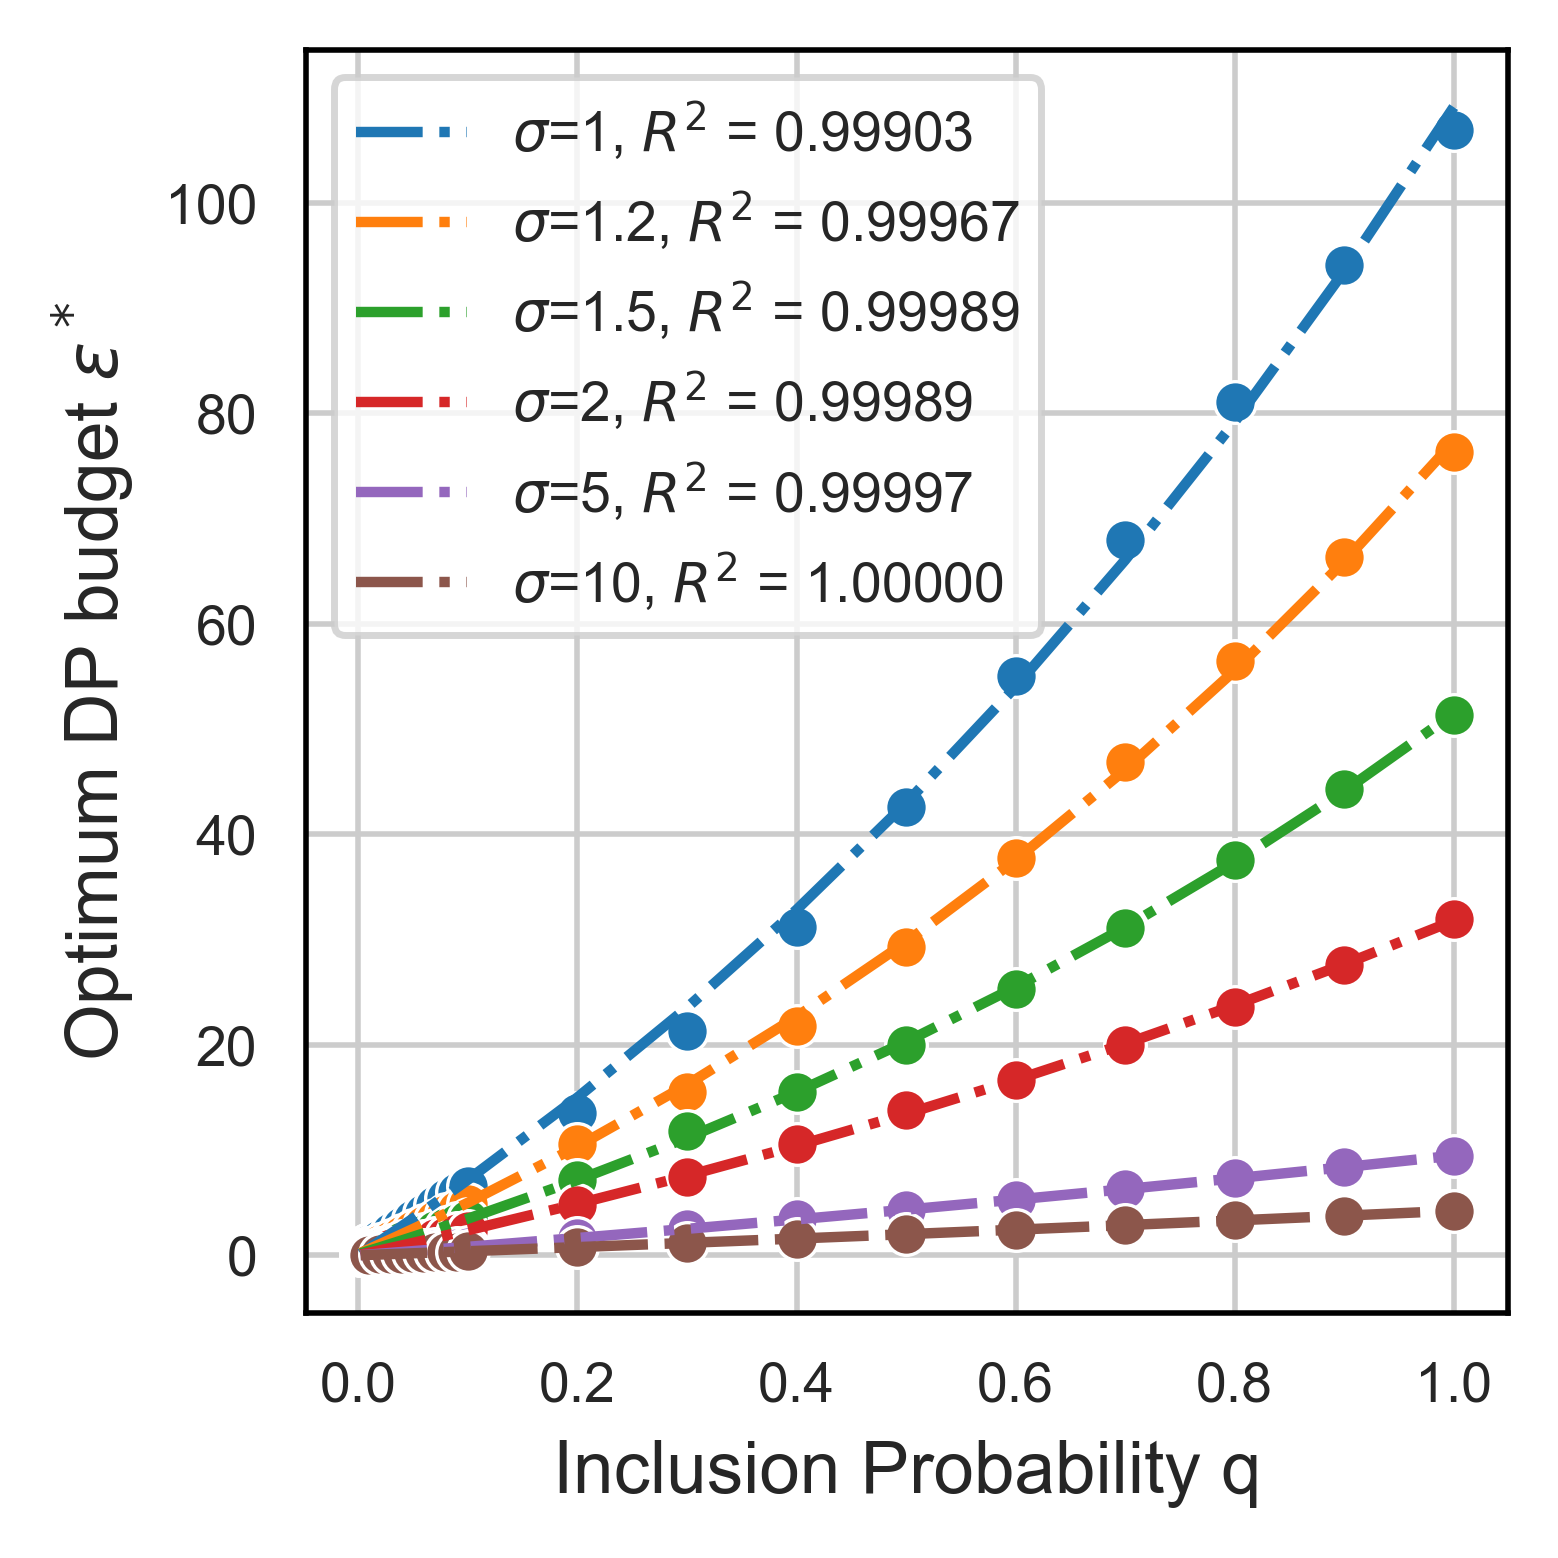

In [19]:
idx_result = [1,1.2,1.5,2,5,10]

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True, dpi=500)

for i in range(6): 
    ydata = np.array(all_results[i]['opt_budget'], dtype=np.float32)
    popt0, pcov = curve_fit(func, sample_rates, ydata)
    score = r2_score(func(sample_rates, *popt0), ydata)
    print(score)

    sns.scatterplot(x=sample_rates, y=all_results[i]['opt_budget'], ax=ax)
    sns.lineplot(x=sample_rates, y=func(sample_rates, *popt0), label=f'$\sigma$={idx_result[i]}, $R^2$ = {score:6.5f}', linestyle='dashdot', ax=ax)

ax.legend(prop=legend_font)
ax.set_ylabel(r'Optimum DP budget $\varepsilon^*$', **label_font)
ax.set_xlabel('Inclusion Probability q', **label_font)
ax.tick_params(labelsize=8) #刻度

# fig.suptitle('The Inclusion Probability Estimation ($\delta$={}, $\sigma$/L={})'.format(target_delta,sigma), fontsize=10, weight='bold')
plt.savefig('inclusion_estimator_sigma.pdf', dpi=500, bbox_inches='tight')
plt.show()